# Лабораторная работа PCA


## Теоретический вопрос №1

> Доказать, что оптимальные направления PCA совпадают с собственными векторами матрицы ковариаций.

PCA ищет векторы, вдоль которых данные имеют максимальную дисперсию. Математически это означает, что мы ищем единичный вектор w, который максимизирует выражение: $$\text{var} (X·w) = w^T · C · w$$
где $X$ это матрица центрированных данных, $C$ - матрица ковариаций, $w$ - искомый единичный вектор.

Другими словами, PCA пытается найти "направления" которые соответствуют направлениям наибольшего разброса данных. Матрица ковариаций характеризует форму и ориентацию: собственные векторы указывают направления осей, а собственные значения определяют длины.

Первая главная компонента (собственный вектор с наибольшим собственным значением) указывает направление, вдоль которого данные варьируются больше всего. Вторая главная компонента перпендикулярна первой и указывает направление второго по величине разброса данных. Последующие компоненты продолжают этот паттерн, при этом всегда оставаясь перпендикулярными всем предыдущим компонентам.


Докажем математически:
Проекция набора данных $X$ на направление $w$ дается выражением $Xw$.
Дисперсия этой проекции: $$ \text{var}(Xw) = w^T C w$$
Мы хотим максимизировать эту дисперсию при ограничении, что $w$ — единичный вектор. Примененим метод множителей Лагранжа: $$L(w, λ) = w^T C w - λ(w^T w - 1)$$, где $λ$ — множитель Лагранжа. Берем производную $L$ по $w$ и приравниваем к нулю: $$∂L/∂w = 2Cw - 2λw = 0 \\ Cw - λw = 0 \\ Cw = λw$$

Полученное уравнение $Cw = λw$ — определение собственного вектора $w$ и собственного значения $λ$ для матрицы $C$. Подставляя собственный вектор $w$ обратно в целевую функцию, получаем: $$w^T C w = w^T (λw) = λw^T w = λ$$ Поскольку w^T w = 1, значение целевой функции равно λ.

Для нахождения второй главной компоненты мы добавляем ограничение ортогональности к первой компоненте: максимизировать: $w^T C w$ при ограничениях $w^T w = 1$ и $w^T w₁ = 0$, где $w₁$ — первая главная компонента.

Решая эту задачу аналогично, получаем, что вторая главная компонента — это собственный вектор, соответствующий второму по величине собственному значению.

Этот процесс можно продолжить для всех компонент.

## Ввод класса Matrix

Для последующей работы введем класс Matrix с нужными для нас функциями, такими как создание матрицы, вставка значений, операции с матрицами и другое.

In [ ]:
class Matrix:
    def __init__(self, rows, cols):
        """ Инициализация матрицы указанного размера """
        self.rows = rows
        self.cols = cols
        # Инициализация матрицы нулями
        self.data = [[0.0 for _ in range(cols)] for _ in range(rows)]

    def set(self, i, j, value):
        """ Установка значения элемента матрицы """
        if 0 <= i < self.rows and 0 <= j < self.cols:
            self.data[i][j] = float(value)
        else:
            raise IndexError(f"Индексы ({i}, {j}) выходят за пределы матрицы размера {self.rows}x{self.cols}")

    def get(self, i, j):
        """ Получение значения элемента матрицы """
        if 0 <= i < self.rows and 0 <= j < self.cols:
            return self.data[i][j]
        else:
            raise IndexError(f"Индексы ({i}, {j}) выходят за пределы матрицы размера {self.rows}x{self.cols}")

    def __mul__(self, scalar):
        """ Умножение матрицы на скаляр """
        if not isinstance(scalar, (int, float)):
            raise TypeError("Скалярное умножение поддерживается только для чисел")

        result = Matrix(self.rows, self.cols)
        for i in range(self.rows):
            for j in range(self.cols):
                result.data[i][j] = self.data[i][j] * scalar
        return result

    def __sub__(self, other):
        """ Вычитание двух матриц """
        if not isinstance(other, Matrix):
            raise TypeError("Операция вычитания поддерживается только между матрицами")
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError("Матрицы должны быть одинакового размера для вычитания")

        result = Matrix(self.rows, self.cols)
        for i in range(self.rows):
            for j in range(self.cols):
                result.data[i][j] = self.data[i][j] - other.data[i][j]
        return result

    def __str__(self):
        """ Строковое представление матрицы для вывода """
        rows_str = []
        for row in self.data:
            rows_str.append("[" + ", ".join([f"{val}" for val in row]) + "]")
        return "\n".join(rows_str)

## Решение СЛАУ

Реализуем решение СЛАУ методом Гаусса. Логика все та же как что и на бумаге, едиснтвенное очень мучительный (лично для меня) процесс реализации. В общем суть следующая:
- Создаем матрицу [A|b]
- Приводим к ступенчатому виду
- Делаем обратный обход
- Получаем ответ

Для удобства функции прямого и обратного обхода были реализованы в отдельных функция gaussian_elimination и back_substitution.

In [ ]:
from typing import List
def gauss_solver(A: Matrix, b: Matrix) -> List[List[float]]:
    n = A.rows
    # построим расширенную матрицу
    aug = Matrix(n, n+1)
    for i in range(n):
        for j in range(n):
            aug.set(i, j, A.get(i, j))
        aug.set(i, n, b.get(i, 0))
    M = gaussian_elimination(aug)
    return back_substitution(M)

def gaussian_elimination(M: Matrix):
    n, m = M.rows, M.cols

    # Создаем копию
    R = Matrix(n, m)
    for i in range(n):
        for j in range(m):
            R.set(i, j, M.get(i, j))

    h = k = 0
    eps = 1e-12

    while h < n and k < m-1:
        # ищем лучшую опору
        i_max, max_val = h, abs(R.get(h,k))
        for i in range(h+1, n):
            v = abs(R.get(i,k))
            if v > max_val:
                i_max, max_val = i, v
        if max_val < eps:
            k += 1
            continue

        # меняем местами строку
        if i_max != h:
            for j in range(m):
                R.set(h, j, R.get(i_max, j))
                R.set(i_max, j, R.get(h, j))

        # обнуляем ниже
        for i in range(h+1, n):
            factor = R.get(i,k)/R.get(h,k)
            R.set(i, k, 0.0)
            for j in range(k+1, m):
                R.set(i, j, R.get(i,j) - factor*R.get(h,j))

        h += 1
        k += 1

    return R

def back_substitution(M: Matrix) -> List[List[float]]:
    n = M.rows
    m = M.cols - 1
    # вычисляем ранк
    rank = sum(
        any(abs(M.get(i,j))>1e-12 for j in range(m))
        for i in range(n)
    )
    # находим опорные столбцы
    pivots = {}
    for i in range(rank):
        for j in range(m):
            if abs(M.get(i,j))>1e-12:
                pivots[j] = i
                break

    free_vars = [j for j in range(m) if j not in pivots]
    basis = []

    for free_j in free_vars:
        sol = [0.0]*m
        sol[free_j] = 1.0
        # обратный ход
        for i in range(rank-1, -1, -1):
            # найдём опорный столбец
            pivot_col = next(
                (j for j in range(m) if abs(M.get(i,j))>1e-12),
                None
            )
            if pivot_col is None:
                continue
            rhs = sum(M.get(i,j)*sol[j] for j in range(pivot_col+1,m))
            sol[pivot_col] = -rhs / M.get(i,pivot_col)
        basis.append(sol)

    # если basis остался пустым
    return basis or [[0.0]*m]


## Центрирования данных

Для реализации центрирования данных используется алгоритм, который находит среднее занчение по каждому столбцу и вычитает его из начальной матрицы. Результат будет центрированная матрица.

In [ ]:
def center_data(matrix):
    # Создаем новую матрицу для центрированных данных
    centered = Matrix(matrix.rows, matrix.cols)

    # Вычисляем среднее по каждому столбцу
    column_means = []
    for j in range(matrix.cols):
        col_sum = 0.0
        for i in range(matrix.rows):
            col_sum += matrix.get(i, j)
        column_means.append(col_sum / matrix.rows)

    # Центрируем данные
    for i in range(matrix.rows):
        for j in range(matrix.cols):
            centered_value = matrix.get(i, j) - column_means[j]
            centered.set(i, j, centered_value)

    return centered

Пример работы:

In [ ]:
# Создаем матрицу 4x3
data = Matrix(4, 3)

# Заполняем матрицу значениями
values = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
    [10, 11, 12]
]

for i in range(4):
    for j in range(3):
        data.set(i, j, values[i][j])

print("Исходная матрица:")
print(data)

centered_data = center_data(data)
print("\nЦентрированная матрица:")
print(centered_data)

Исходная матрица:
[1.0, 2.0, 3.0]
[4.0, 5.0, 6.0]
[7.0, 8.0, 9.0]
[10.0, 11.0, 12.0]

Центрированная матрица:
[-4.5, -4.5, -4.5]
[-1.5, -1.5, -1.5]
[1.5, 1.5, 1.5]
[4.5, 4.5, 4.5]


## Матрицы ковариаций

Основной алгоритм:
- Для каждой пары признаков вычисляем сумму произведений центрированных значений для всех наблюдений k
- Делим сумму на $n-1$ для получения несмещенной оценки ковариации
- Сохраняем результат в матрице, оно и будет матрицей ковариаций

Стоит так же учесть что матрица ковариаций квадратная.

In [ ]:
def covariance_matrix(centered_matrix):
    # Размеры матрицы
    n = centered_matrix.rows  # наблюдения
    p = centered_matrix.cols  # признаки

    # Создаем матрицу ковариаций размера p x p
    cov_matrix = Matrix(p, p)

    for i in range(p):
        for j in range(p):
            # Вычисляем ковариацию между i-м и j-м признаками
            covariance = 0.0
            for k in range(n):
                covariance += centered_matrix.get(k, i) * centered_matrix.get(k, j)

            # Делим на n-1 для несмещенной оценки ковариации
            covariance /= (n - 1)

            cov_matrix.set(i, j, covariance)

    return cov_matrix

Пример работы:

In [ ]:
print("Исходная матрица:")
print(data)

# Вычисляем матрицу ковариаций
cov_mat = covariance_matrix(centered_data)
print("\nМатрица ковариаций:")
print(cov_mat)

Исходная матрица:
[1.0, 2.0, 3.0]
[4.0, 5.0, 6.0]
[7.0, 8.0, 9.0]
[10.0, 11.0, 12.0]

Матрица ковариаций:
[15.0, 15.0, 15.0]
[15.0, 15.0, 15.0]
[15.0, 15.0, 15.0]


## Собсвтенное значени

Реализуем функции для поиска определителя. Для этого нам понадобятся все те же знания линейной алгербры.

Детерминант у $(C- \lambda I) = 0$. Исходя из этого, по наработанной на практике опытом, нужно найти такое $\lambda$, что бы урованение давало нулевой определитель.

Релизуй функцию для поиска определителя, после чего перейдем к самому поиску собственного значения.

In [ ]:
def determinant(matrix):
    n = matrix.rows

    if n == 1:
        return matrix.get(0, 0)
    if n == 2:
        return matrix.get(0, 0) * matrix.get(1, 1) - matrix.get(0, 1) * matrix.get(1, 0)

    # разложение по первой строке
    det = 0
    for j in range(n):
        # Создаем подматрицу, исключая первую строку и j-й столбец
        submatrix = Matrix(n-1, n-1)
        for row in range(1, n):
            col_idx = 0
            for col in range(n):
                if col != j:
                    submatrix.set(row-1, col_idx, matrix.get(row, col))
                    col_idx += 1

        # Добавляем к определителю с учетом знака (-1)^(i+j)
        sign = 1 if j % 2 == 0 else -1
        det += sign * matrix.get(0, j) * determinant(submatrix)

    return det

Перейдем к самому поиску собсвтенного значения.

Для реализации функции нужно было применить метод бисекции. Его суть заключаетяс в том, что мы делим весь интервал и ищем когда лямда будет равна нулю. Если на каком-то интервале меняется знак, значит там есть такое число что дает ноль. При слишком малых числах в результатах мы записываем лямду как ответ. Так же может быть такое, что нам не хватает количество итераций, и мы записываем среднее значение интервала.

In [ ]:
def find_eigenvalues(matrix, tol=1e-6, max_iterations=100, search_min=-100, search_max=100):
    """ Находит собственные значения матрицы методом бисекции """

    n = matrix.rows
    eigenvalues = []

    # Создаем единичную матрицу
    identity = Matrix(n, n)
    for i in range(n):
        identity.set(i, i, 1.0)

    # Функция для вычисления определителя матрицы (C - lambda*I)
    def det_characteristic(lambda_val):
        lambda_matrix = identity * lambda_val
        c_minus_lambda_i = matrix.__sub__(lambda_matrix)
        return determinant(c_minus_lambda_i)

    # Разбиваем интервал поиска на подинтервалы для первичного поиска смены знака
    step = (search_max - search_min) / 100
    prev_lambda = search_min
    prev_det = det_characteristic(prev_lambda)

    # Ищем интервалы, где определитель меняет знак
    for i in range(1, 101):
        curr_lambda = search_min + i * step
        curr_det = det_characteristic(curr_lambda)

        # Если определитель близок к нулю, считаем значение собственным числом
        if abs(curr_det) < tol:
            eigenvalues.append(curr_lambda)
        # Если знак определителя изменился, применяем метод бисекции
        elif prev_det * curr_det < 0:
            # Метод бисекции
            a, b = prev_lambda, curr_lambda
            fa, fb = prev_det, curr_det

            for _ in range(max_iterations):
                # Средняя точка
                c = (a + b) / 2
                fc = det_characteristic(c)

                # Если определитель достаточно близок к нулю
                if abs(fc) < tol:
                    eigenvalues.append(c)
                    break

                # Определяем новый интервал поиска
                if fa * fc < 0:
                    b, fb = c, fc
                else:
                    a, fa = c, fc

                # Проверка на достаточную точность по аргументу
                if abs(b - a) < tol:
                    eigenvalues.append((a + b) / 2)
                    break

            # Если после максимального числа итераций не достигли нужной точности,
            # возьмем среднее значение интервала
            else:
                eigenvalues.append((a + b) / 2)

        prev_lambda = curr_lambda
        prev_det = curr_det

    # Удаление дубликатов
    # unique_eigenvalues = []
    # for val in eigenvalues:
    #     is_duplicate = False
    #     for unique_val in unique_eigenvalues:
    #         if abs(val - unique_val) < tol:
    #             is_duplicate = True
    #             break
    #     if not is_duplicate:
    #         unique_eigenvalues.append(val)

    return eigenvalues

In [ ]:
# Пример использования для матрицы 2x2
matrix = Matrix(2, 2)
matrix.set(0, 0, 4)
matrix.set(0, 1, 1)
matrix.set(1, 0, 2)
matrix.set(1, 1, 3)

print(matrix)
# Поиск собственных значений методом бисекции
eigenvalues = find_eigenvalues(matrix)
print("Собственные значения матрицы:")
for val in eigenvalues:
    print(f"λ = {val}")


[4.0, 1.0]
[2.0, 3.0]
Собственные значения матрицы:
λ = 2.0
λ = 5.0


## Собственный вектор

Для нахождения собственного вектора нужно вычесть из матрицы единичную матрицу собственного значения и решить однородное СЛАУ.

In [ ]:
def find_eigenvectors(matrix, eigenvalues: list[float]):
    """ Находит собственные векторы матрицы """

    n = matrix.rows
    result = {}

    b = Matrix(n, 1)
    for i in range(n):
        b.set(i, 0, 0.0)

    for eigenvalue in eigenvalues:
        # Собираем матрицу
        # Создаем копию матрицы
        c_minus_lambda_i = Matrix(n, n+1)
        for i in range(n):
            for j in range(n):
                c_minus_lambda_i.set(i, j, matrix.get(i, j))
            # Последний столбец нулевой
            c_minus_lambda_i.set(i, n, 0.0)

        for i in range(matrix.rows):
            c_minus_lambda_i.set(i, i,
                c_minus_lambda_i.get(i, i) - eigenvalue
            )

        # Решаем однородную СЛАУ
        basis = gauss_solver(c_minus_lambda_i, b)
        if not basis:
            continue

        eigenvector = basis[0]

        # Нормируем
        norm = sum(x*x for x in eigenvector) ** 0.5
        if norm > 1e-10:
            normalized = [x / norm for x in eigenvector]
        else:
            normalized = eigenvector  # останется как есть, если норма ≈ 0

        result[eigenvalue] = normalized

    return result

In [ ]:
# Пример использования для матрицы 2x2
matrix = Matrix(2, 2)
matrix.set(0, 0, 4)
matrix.set(0, 1, 1)
matrix.set(1, 0, 2)
matrix.set(1, 1, 3)

# Поиск собственных значений
eigenvalues = find_eigenvalues(matrix)
print("Собственные значения матрицы:")
for val in eigenvalues:
    print(f"λ = {val}")

# Поиск собственных векторов
eigenvectors = find_eigenvectors(matrix, eigenvalues)
print("\nСобственные векторы:")
for eigenvalue, eigenvector in eigenvectors.items():
    print(f"Для λ = {eigenvalue}: {eigenvector}")

Собственные значения матрицы:
λ = 2.0
λ = 5.0

Собственные векторы:
Для λ = 2.0: [-0.4472135954999579, 0.8944271909999159]
Для λ = 5.0: [0.7071067811865475, 0.7071067811865475]


## Доля объясненной дисперсии

Дисперсия - это метрика разброса параметра. Объясненная дисперсия дает понять какая часть общей изменчивости данных объясняется каждой главной компонентой после применения метода.

In [ ]:
def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:
    """ Вычисление доли объяснённой дисперсии """

    # сумма всех собственных значений
    total_variance = sum(eigenvalues)

    # дисперсия, объяснённая первыми k компонентами
    explained_variance = sum(eigenvalues[:k])

    # доля объяснённой дисперсии
    explained_variance_ratio = explained_variance / total_variance

    return explained_variance_ratio

In [ ]:
# Пример использования
eigenvalues = [4.0, 2.0, 1.0, 0.5]
k = 2
evr = explained_variance_ratio(eigenvalues, k)
print(f"Доля объяснённой дисперсии для первых {k} компонент: {evr}")

Доля объяснённой дисперсии для первых 2 компонент: 0.8


## Полный алгоритм PCA

Воспользуемся всем тем, что мы уже написали и соеденим все такой вещью как "логика". Если выводить алгоритм работы, то он следующий:
- Центрируем данные
- Вычисляем ковариационную матрицу
- Находим собсвтенный вектор
- Сортируем айгенвектора и айгензначения
- Отбираем k значений
- Делаем матрицу проекций и проецируем на пространство главных компонентов
- Находим долю объяснённой дисперсии


In [ ]:
from typing import Tuple, Dict, List

def pca(X: Matrix, k: int) -> Tuple[Matrix, float]:
    # Центрирование данных
    X_centered = center_data(X)

    # Вычисление ковариационной матрицы
    cov_matrix = covariance_matrix(X_centered)

    # Нахождение собственных значений
    eigenvalues = find_eigenvalues(cov_matrix)

    # Нахождение собственных векторов
    eigenvectors_dict = find_eigenvectors(cov_matrix, eigenvalues)

    # Сортировка собственных значений и векторов по убыванию
    sorted_eigenvalues = sorted(eigenvalues, reverse=True)

    # Отбираем только первые k собственных значений и соответствующие им векторы
    k = min(k, len(sorted_eigenvalues))
    top_k_eigenvalues = sorted_eigenvalues[:k]

    # Формируем матрицу проекции
    n_features = X.cols
    projection_matrix = Matrix(k, n_features)
    for i in range(k):
        eigenvalue = top_k_eigenvalues[i]
        eigenvector = eigenvectors_dict.get(eigenvalue, [])

        # Записываем собственный вектор в матрицу проекции
        for j in range(len(eigenvector)):
            projection_matrix.set(i, j, eigenvector[j])

    # Проекция данных на пространство главных компонент
    # X_centered [n_samples, n_features], projection_matrix' [n_features, k]
    # результат: [n_samples, k]
    n_samples = X.rows
    projected_data = Matrix(n_samples, k)

    for i in range(n_samples):
        for j in range(k):
            # Скалярное произведение i-й строки центрированных данных и j-го собственного вектора
            dot_product = 0.0
            for l in range(n_features):
                dot_product += X_centered.get(i, l) * projection_matrix.get(j, l)
            projected_data.set(i, j, dot_product)

    # Вычисление доли объяснённой дисперсии
    explained_var_ratio = explained_variance_ratio(sorted_eigenvalues, k)

    return projected_data, explained_var_ratio

In [ ]:
X = Matrix(3, 3)
X.set(0, 0, 2); X.set(0, 1, 1); X.set(0, 2, 3)
X.set(1, 0, 4); X.set(1, 1, 2); X.set(1, 2, 4)
X.set(2, 0, 5); X.set(2, 1, 1); X.set(2, 2, 4)


# Применяем PCA для 2 главных компонент
projected_data, evr = pca(X, k=2)

print("Проекция данных на 2 главные компоненты:")
for i in range(projected_data.rows):
    print([projected_data.get(i, j) for j in range(projected_data.cols)])

print(f"Доля объяснённой дисперсии: {evr:.2f}")

Проекция данных на 2 главные компоненты:
[-1.8172760982835927, 1.1102230246251565e-16]
[0.4869376515434315, 0.0]
[1.330338446740162, 1.6653345369377348e-16]
Доля объяснённой дисперсии: 1.00


## Визуализация

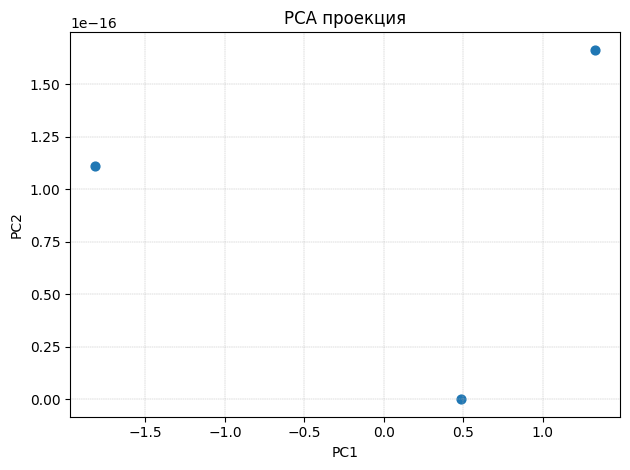

In [ ]:
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

def plot_pca_projection(X_proj: 'Matrix') -> Figure:
    x = [X_proj.get(i, 0) for i in range(X_proj.rows)]
    y = [X_proj.get(i, 1) for i in range(X_proj.rows)]

    fig, ax = plt.subplots()
    ax.scatter(x, y, s=40)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("PCA проекция")
    ax.grid(True, ls="--", lw=0.3)
    fig.tight_layout()

    return fig

fig = plot_pca_projection(projected_data)
fig.show()

Видно, что разброс есть

## Вычесление MAE

Метод MAE говорит о среднеквадротичной ошибке, то есть квадратная разность элемнтов матриц начальной и новой, деленная на всю размерность $(n \times m)$.

In [ ]:
def reconstruction_error(X_orig: 'Matrix', X_recon: 'Matrix') -> float:
    """ Вычисляет MSE между исходными и восстановленными данными """

    n_samples = X_orig.rows
    n_features = X_orig.cols
    total_elements = n_samples * n_features

    # Сумма квадратов разностей
    squared_error_sum = 0.0

    for i in range(n_samples):
        for j in range(n_features):
            # Разница между элементами
            diff = X_orig.get(i, j) - X_recon.get(i, j)
            # Квадрат разницы
            squared_error_sum += diff * diff

    # Среднее значение суммы квадратов разностей
    mse = squared_error_sum / total_elements

    return mse

In [ ]:
X_o = Matrix(2, 2)
X_o.set(0, 0, 1)
X_o.set(0, 1, 2)
X_o.set(1, 0, 3)
X_o.set(1, 1, 4)

X_r = Matrix(2, 2)
X_r.set(0, 0, 0.9)
X_r.set(0, 1, 2.1)
X_r.set(1, 0, 3.2)
X_r.set(1, 1, 3.8)

mse  = reconstruction_error(X_o, X_r)
print("MSE =", mse)


MSE = 0.025000000000000036


## Автоматический выбор числа главных компонент

Суть нахождения заключается в формулке:
$$
k = \min\Biggl\{\,k \;\colon\;
\frac{\displaystyle\sum_{i=1}^k \lambda_i}
     {\displaystyle\sum_{i=1}^m \lambda_i}
\ge \text{threshold}
\Biggr\}.
$$

На ее основе мы и ищем подхожящее k

In [ ]:
def auto_select_k(eigenvalues: List[float], threshold: float = 0.95) -> int:
    """ Автоматически выбор оптимального числа главных компонентов """

    # Находим минимальное k, при котором доля объясненной дисперсии >= threshold
    for k in range(len(eigenvalues)):
        k += 1
        cumulative_variance_ratio = explained_variance_ratio(eigenvalues, k)
        # cumulative_variance_ratio += eigenvalue / total_variance
        if cumulative_variance_ratio >= threshold:
            return k

    return len(eigenvalues)

Для наглядности и собственного понимания я представил в добавок
к примеру наглядные графики, которые дают понять такой выбор.

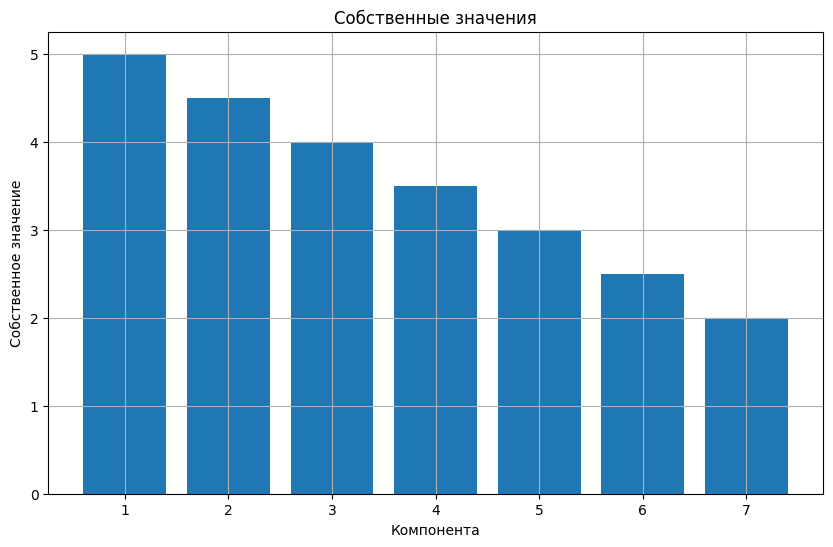

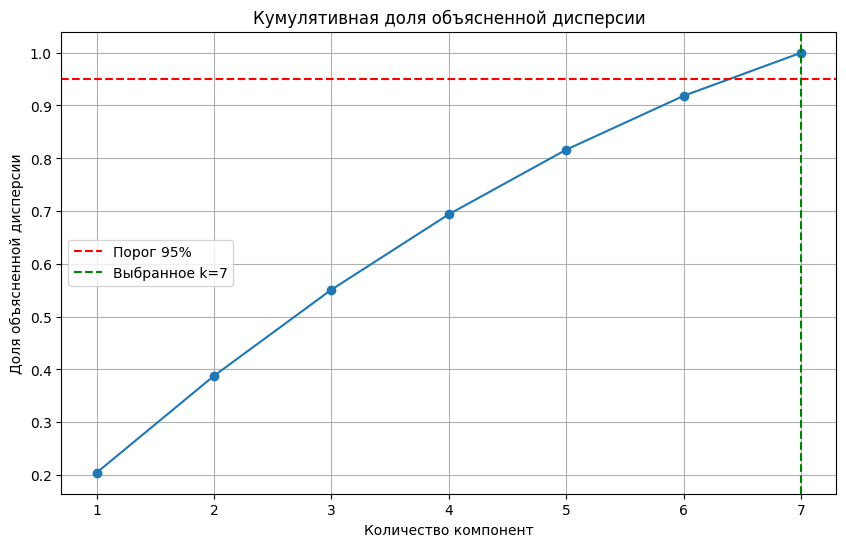


Собственные значения = [5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0]
Выбранное k = 7
Доля объясненной дисперсии при k=7: 1.0000


In [ ]:
eigenvalues2 = [5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0]
k2 = auto_select_k(eigenvalues2)

total2 = sum(eigenvalues2)
cumulative_variance2 = [sum(sorted(eigenvalues2, reverse=True)[:i+1])/total2 for i in range(len(eigenvalues2))]

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(eigenvalues2)+1), eigenvalues2)
plt.xlabel('Компонента')
plt.ylabel('Собственное значение')
plt.title('Собственные значения')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues2)+1), cumulative_variance2, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='Порог 95%')
plt.axvline(x=k2, color='g', linestyle='--', label=f'Выбранное k={k2}')
plt.xlabel('Количество компонент')
plt.ylabel('Доля объясненной дисперсии')
plt.title('Кумулятивная доля объясненной дисперсии')
plt.grid(True)
plt.legend()
plt.show()

print(f"\nСобственные значения = {eigenvalues2}")
print(f"Выбранное k = {k2}")
print(f"Доля объясненной дисперсии при k={k2}: {cumulative_variance2[k2-1]:.4f}")

Добавим в уже написанную нами функцию PCA автомататический выбор k

In [ ]:
# def pca_auto(X: Matrix, threshold: float = 0.95) -> Tuple[Matrix, float, int]:
#     """ Выполняет PCA с автоматическим выбором числа компонент. """
#     # Центрирование данных и вычисление ковариационной матрицы
#     X_centered = center_data(X)
#     cov_matrix = covariance_matrix(X_centered)

#     # Нахождение собственных значений
#     eigenvalues = find_eigenvalues(cov_matrix)

#     # Автоматический выбор k на основе порога
#     k = auto_select_k(eigenvalues, threshold)

#     # Выполнение PCA с выбранным k
#     projected_data, explained_variance = pca(X, k)

#     return projected_data, explained_variance, k

In [ ]:
def pca_auto(X: Matrix, threshold: float = 0.95) -> Tuple[Matrix, float]:
    # Центрирование данных
    X_centered = center_data(X)

    # Вычисление ковариационной матрицы
    cov_matrix = covariance_matrix(X_centered)

    # Нахождение собственных значений
    eigenvalues = find_eigenvalues(cov_matrix)

    # Нахождение собственных векторов
    eigenvectors_dict = find_eigenvectors(cov_matrix, eigenvalues)

    # Сортировка собственных значений и векторов по убыванию
    sorted_eigenvalues = sorted(eigenvalues, reverse=True)

    # Автоматический выбор k на основе порога
    k = auto_select_k(eigenvalues, threshold)

    # Отбираем только первые k собственных значений и соответствующие им векторы
    k = min(k, len(sorted_eigenvalues))
    top_k_eigenvalues = sorted_eigenvalues[:k]

    # Формируем матрицу проекции
    n_features = X.cols
    projection_matrix = Matrix(k, n_features)
    for i in range(k):
        eigenvalue = top_k_eigenvalues[i]
        eigenvector = eigenvectors_dict.get(eigenvalue, [])

        # Записываем собственный вектор в матрицу проекции
        for j in range(len(eigenvector)):
            projection_matrix.set(i, j, eigenvector[j])

    # Проекция данных на пространство главных компонент
    # X_centered [n_samples, n_features], projection_matrix' [n_features, k]
    # Результат: [n_samples, k]
    n_samples = X.rows
    projected_data = Matrix(n_samples, k)

    for i in range(n_samples):
        for j in range(k):
            # Скалярное произведение i-й строки центрированных данных и j-го собственного вектора
            dot_product = 0.0
            for l in range(n_features):
                dot_product += X_centered.get(i, l) * projection_matrix.get(j, l)
            projected_data.set(i, j, dot_product)

    # Вычисление доли объяснённой дисперсии
    explained_var_ratio = explained_variance_ratio(sorted_eigenvalues, k)

    return projected_data, explained_var_ratio

In [ ]:
X = Matrix(3, 3)
X.set(0, 0, 2); X.set(0, 1, 1); X.set(0, 2, 3)
X.set(1, 0, 4); X.set(1, 1, 2); X.set(1, 2, 4)
X.set(2, 0, 5); X.set(2, 1, 1); X.set(2, 2, 4)


projected_data, evr = pca_auto(X)

print(f"Автоматический выбор k: {k}")
print(f"Проекция данных на {k} главные компоненты:")
for i in range(projected_data.rows):
    print([projected_data.get(i, j) for j in range(projected_data.cols)])

print(f"Доля объяснённой дисперсии: {evr:.2f}")

Автоматический выбор k: 2
Проекция данных на 2 главные компоненты:
[-1.8172760982835927, 1.1102230246251565e-16]
[0.4869376515434315, 0.0]
[1.330338446740162, 1.6653345369377348e-16]
Доля объяснённой дисперсии: 1.00


## Обработка пропущенных значений

Логика обработки проста: если есть NaN объект, то вписываем среднее по всему столбцу.

In [ ]:
import math

def handle_missing_values(X: 'Matrix') -> 'Matrix':
    """ Обработка пропущенных значений (NaN) в матрице """
    # Создаем новую матрицу того же размера
    rows, cols = X.rows, X.cols
    X_filled = Matrix(rows, cols)

    # Для каждого столбца вычисляем среднее значение (исключая NaN)
    column_means = []
    for j in range(cols):
        values = []
        for i in range(rows):
            value = X.get(i, j)
            # Проверяем, не является ли значение NaN
            if not (math.isnan(value) if hasattr(math, 'isnan') else (value != value)):
                values.append(value)

        # Вычисляем среднее значение столбца
        mean = sum(values) / len(values) if values else 0.0
        column_means.append(mean)

    # Заполняем новую матрицу, заменяя NaN на средние значения
    for i in range(rows):
        for j in range(cols):
            value = X.get(i, j)
            # Проверяем, является ли значение NaN
            if math.isnan(value) if hasattr(math, 'isnan') else (value != value):
                # Если значение NaN, заменяем его на среднее по столбцу
                X_filled.set(i, j, column_means[j])
            else:
                # Если значение не NaN, сохраняем его
                X_filled.set(i, j, value)

    return X_filled

In [ ]:
X = Matrix(3, 3)
X.set(0, 0, 1); X.set(0, 1, float('nan')); X.set(0, 2, 3)
X.set(1, 0, float('nan')); X.set(1, 1, 2); X.set(1, 2, 5)
X.set(2, 0, 2); X.set(2, 1, 4); X.set(2, 2, float('nan'))

print(f"Начальная матрица: \n{X}")
print("---------------")
print(f"После обработки: \n{handle_missing_values(X)}")

Начальная матрица: 
[1.0, nan, 3.0]
[nan, 2.0, 5.0]
[2.0, 4.0, nan]
---------------
После обработки: 
[1.0, 3.0, 3.0]
[1.5, 2.0, 5.0]
[2.0, 4.0, 4.0]


## Иследования влияния шума на PCA

Для иследования нужно создать "шум". Вычеслим стандартное отклонение каждого признака по следующей формуле:
$$
\sqrt{\frac{1}{n}
  \sum_{i=1}^{n} \bigl(X_{ij} - \bar X_j\bigr)^2}
$$
$X$ - начальная матрица \
$\bar X$ - матрица, в которой задана сумма каждого столбца деленная на $n$ \
$n$ - количесвто строк


После чего была использованна функция random, которая и давала шуму используя найденные выше параметры (получилось нармальное распределение).

Далее применяем PCA и анализируем.

In [ ]:
import random
import math
from typing import Tuple, Dict, List

def add_noise_and_compare(X: 'Matrix', noise_level: float = 0.1, k: int = 2):
    """ Исследует влияние шума на результаты PCA """
    # вычисляем стандартное отклонения по каждому признаку
    n_samples = X.rows
    n_features = X.cols

    means = [0.0] * n_features
    for j in range(n_features):
        sum_col = 0.0
        for i in range(n_samples):
            sum_col += X.get(i, j)
        means[j] = sum_col / n_samples

    std_devs = [0.0] * n_features
    for j in range(n_features):
        sum_squared_diff = 0.0
        for i in range(n_samples):
            diff = X.get(i, j) - means[j]
            sum_squared_diff += diff * diff
        std_devs[j] = math.sqrt(sum_squared_diff / n_samples)

    # Созданаем матрицу с шумом
    X_noisy = Matrix(n_samples, n_features)
    for i in range(n_samples):
        for j in range(n_features):
            # Генерация случайного шума (нормальное распределение)
            noise = random.gauss(0, std_devs[j] * noise_level)
            X_noisy.set(i, j, X.get(i, j) + noise)

    # Применение PCA к исходным данным
    original_pca_result = pca(X, k)

    # Применение PCA к зашумленным данным
    noisy_pca_result = pca(X_noisy, k)

    # Формирование результата
    return original_pca_result, noisy_pca_result, X_noisy

def compare_pca_results(original_result: Tuple['Matrix', float],
                       noisy_result: Tuple['Matrix', float],
                       noise_level: float = 0.1):
    """ Анализ и сравнение результатов PCA до и после шума """
    original_projection, original_explained_var = original_result
    noisy_projection, noisy_explained_var = noisy_result

    # Вычисление среднеквадратичного отклонения проекций
    n_samples = original_projection.rows
    n_components = original_projection.cols

    mse = reconstruction_error(original_projection, noisy_projection)

    # Вычисление относительного изменения объясненной дисперсии
    explained_var_change = (noisy_explained_var - original_explained_var) / original_explained_var

    # Формирование результата
    comparison = {
        "уровень шума": noise_level,
        "изначальная дисперсия ": original_explained_var,
        "шумная дисперсия": noisy_explained_var,
        "относительное изменение дисперсии": explained_var_change,
        "MSE": mse,
        "относительная ошибка": math.sqrt(mse) / math.sqrt(n_samples * n_components)
    }

    return comparison

In [ ]:
# Пример использования
X = Matrix(3, 3)
X.set(0, 0, 2); X.set(0, 1, 1); X.set(0, 2, 3)
X.set(1, 0, 4); X.set(1, 1, 2); X.set(1, 2, 4)
X.set(2, 0, 5); X.set(2, 1, 1); X.set(2, 2, 4)

# Добавление шума и применение PCA
original_result, noisy_result, X_noisy = add_noise_and_compare(X, noise_level=0.1, k=2)

# Анализ результатов
comparison = compare_pca_results(original_result, noisy_result, noise_level=0.1)

print("Исходные данные:")
print(X)
print("\nДанные с шумом:")
print(X_noisy)
print("\nPCA на исходных данных:")
print(original_result[0])
print("Объясненная дисперсия:", original_result[1])
print("\nPCA на данных с шумом:")
print(noisy_result[0])
print("Объясненная дисперсия:", noisy_result[1])
print("\nСравнение результатов:")
print(comparison)

Исходные данные:
[2.0, 1.0, 3.0]
[4.0, 2.0, 4.0]
[5.0, 1.0, 4.0]

Данные с шумом:
[2.1303804120787726, 0.9244758479491924, 2.9121410678513437]
[4.03896980482663, 1.9939657968738074, 4.077621785902444]
[4.869318693369989, 1.0401376517293115, 3.99439148466242]

PCA на исходных данных:
[-1.8172760982835927, 1.1102230246251565e-16]
[0.4869376515434315, 0.0]
[1.330338446740162, 1.6653345369377348e-16]
Объясненная дисперсия: 1.0

PCA на данных с шумом:
[-1.7615097458563795, -3.3306690738754696e-16]
[0.6014530326916661, -1.1102230246251565e-16]
[1.1600567131647144, -1.6653345369377348e-16]
Объясненная дисперсия: 1.0

Сравнение результатов:
{'уровень шума': 0.1, 'изначальная дисперсия ': 1.0, 'шумная дисперсия': 1.0, 'относительное изменение дисперсии': 0.0, 'MSE': 0.007536587895336885, 'относительная ошибка': 0.03544147263526373}


## PCA на Dataset

Для демонстрации PCA подойдет датасет Iris Species с Kaggle, который cодержит измерения 4 характеристик цветков ириса (размерности лепестков и чашелистиков) и имеет 3 класса (3 вида ириса)


In [ ]:
import csv

def load_dataset_to_matrix(filename: str) -> 'Matrix':
    """ Загружает датасет """


def apply_pca_to_dataset(dataset_name: str):
    """ Применяет PCA к датасету """


In [ ]:
# dataset = "Iris.csv"

# projected_data, explained_variance = apply_pca_to_dataset(dataset)